In [1]:
import pandas as pd
from pandas import DataFrame
import random
from copy import deepcopy
import math
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as coint

# Backtrader
import backtrader as bt

# PyQuantTrader
from PyQuantTrader import strategy as pqt_strategy
from PyQuantTrader import validation as pqt_val
from PyQuantTrader import analyzers as pqt_ana
from PyQuantTrader import indicators as pqt_ind
from PyQuantTrader import observers as pqt_obs
from PyQuantTrader import sizers as pqt_sizers

# OandaAPI
import oandapy

/home/Common/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Indicators
class OLS_HedgeRatio(bt.ind.PeriodN):
    '''
    Calculates a linear regression using ``statsmodel.OLS`` (Ordinary least
    squares) of data1 on data0
    Uses ``pandas`` and ``statsmodels``
    '''
    _mindatas = 2  # ensure at least 2 data feeds are passed

    packages = (
        ('pandas', 'pd'),
        ('statsmodels.api', 'sm'),
    )
    lines = ('slope', 'intercept',)
    params = (('period', 10),)

    def next(self):
        p0 = pd.Series(self.data0.get(size=self.p.period))
        p1 = pd.Series(self.data1.get(size=self.p.period))
        p1 = sm.add_constant(p1, prepend=True)
        slope, intercept = sm.OLS(p0, p1).fit().params

        self.lines.slope[0] = slope
        self.lines.intercept[0] = intercept

class OLS_Zscore(bt.ind.PeriodN):
    '''
    Calculates the ``zscore`` for data0 and data1. Although it doesn't directly
    uses any external package it relies on ``OLS_HedgeRatio`` which uses
    ``pandas`` and ``statsmodels``
    '''
    _mindatas = 2  # ensure at least 2 data feeds are passed
    lines = ('spread', 'spread_mean', 'spread_std', 'zscore',)
    params = (('period', 10),)

    def __init__(self):
        slint = OLS_HedgeRatio(*self.datas)

        spread = self.data0 - (slint.slope * self.data1 + slint.intercept)
        self.l.spread = spread

        self.l.spread_mean = bt.ind.SMA(spread, period=self.p.period)
        self.l.spread_std = bt.ind.StdDev(spread, period=self.p.period)
        self.l.zscore = (spread - self.l.spread_mean) / self.l.spread_std

In [3]:
# Sizer
class MeanReversionSizer(bt.Sizer):
    '''
    Proportion sizer
    '''
    params = {"prop": 0.05}
 
    def _getsizing(self, comminfo, cash, data, isbuy):
        """Returns the proper sizing"""
        target = self.broker.getvalue() * self.params.prop    # Ideal total value of the position
        price = data.close[0]
        qty = int(target / price)    # The actual number of shares bought
        if qty * price > cash:
            return 0    # Not enough money for this trade
        else:
            return qty
        # return self.broker.getposition(data).size    # Clear the position

In [4]:
# Strategy
class MeanReversionSt(bt.Strategy):  
    
    params = dict(
            hold = [120,120],
            lookback = 120,
            zs_thres = 2
            )

    def log(self, txt, dt=None):  
        ''''' Logging function fot this strategy'''  
        dt = dt or self.datas[0].datetime.datetime(0)  
        print('%s, %s' % (dt.isoformat(), txt))  

    def __init__(self):  
        #self.sma1 = bt.indicators.SMA(self.data1.close, period=15)
        
        self.o = dict() # orders per data (main, stop, limit, manual-close)
        self.holding = dict() # holding periods per data
        self.qty = dict() # qty taken per data
        ols_hedge = OLS_HedgeRatio()
        ols_zscore = OLS_Zscore()
        self.hedgeRatio = ols_hedge.lines.slope
        self.zscore = ols_zscore.lines.zscore
        
    def start(self):  
        print("the world call me!")  
  
    def prenext(self):  
        print("not mature")  
  
    def next(self):  
        
        self.log('OLS Hedge Ratio: %.4f | ZScore: %.4f' % (self.hedgeRatio[0], self.zscore[0]))

        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.datetime(), d._name
            pos = self.getposition(d).size
            print('{} {} Position {}'.format(dt, dn, pos))
            
            if self.zscore[0] >= self.p.zs_thres:
                # go Short
                if i == 0:
                    o1 = self.sell(data=d)
                    self.qty[0] = o1.size
                elif i == 1:
                    self.buy(data=d, size=int(self.qty[0]*self.hedgeRatio[0]))
                
            elif self.zscore[0] <= -self.p.zs_thres:
                # go Long
                if i == 0:
                    o1 = self.buy(data=d)
                    self.qty[0] = o1.size
                elif i == 1:
                    self.sell(data=d, size=int(self.qty[0]*self.hedgeRatio[0]))
                self.holding[d] = 0
            elif pos:
                # close postions
                self.holding[d] += 1
                if self.holding[d] >= self.p.hold[i]:
                    self.close(data=d)
                    

In [5]:
# Oanda data
account = "101-011-6029361-001"
access_token="8153764443276ed6230c2d8a95dac609-e9e68019e7c1c51e6f99a755007914f7"
account_type = "practice"
# Register APIs
oanda = oandapy.API(environment=account_type, access_token=access_token)
# Get historical prices
hist = oanda.get_history(instrument = "AUD_USD", granularity = "M15", count = 5000, candleFormat = "midpoint")
dataframe = pd.DataFrame(hist['candles'])
dataframe['openinterest'] = 0 
dataframe = dataframe[['time', 'openMid', 'highMid', 'lowMid', 'closeMid', 'volume', 'openinterest']]
dataframe['time'] = pd.to_datetime(dataframe['time'])
dataframe = dataframe.set_index('time')
dataframe = dataframe.rename(columns={'openMid': 'open', 'highMid': 'high', 'lowMid': 'low', 'closeMid': 'close'})
AUDUSD = bt.feeds.PandasData(dataname=dataframe)  

hist = oanda.get_history(instrument = "USD_CAD", granularity = "M15", count = 5000, candleFormat = "midpoint")
dataframe = pd.DataFrame(hist['candles'])
dataframe['openinterest'] = 0 
dataframe = dataframe[['time', 'openMid', 'highMid', 'lowMid', 'closeMid', 'volume', 'openinterest']]
dataframe['time'] = pd.to_datetime(dataframe['time'])
dataframe = dataframe.set_index('time')
dataframe = dataframe.rename(columns={'openMid': 'open', 'highMid': 'high', 'lowMid': 'low', 'closeMid': 'close'})
USDCAD = bt.feeds.PandasData(dataname=dataframe)  

In [6]:
n_cores = 7
cash = 10000
leverage = 20
init_assets = cash * leverage
positions = init_assets * 0.02

# Initialize
cerebro = bt.Cerebro(maxcpus=n_cores)

# Data feed
cerebro.adddata(AUDUSD, name ="AUDUSD")
cerebro.adddata(USDCAD, name ="USDCAD")

# Broker
cerebro.broker.set_cash(init_assets)
cerebro.broker.setcommission(0.0002)
    
# Sizer
cerebro.addsizer(MeanReversionSizer)

# Analyzer
cerebro.addanalyzer(bt.analyzers.PyFolio)

# Strategy
cerebro.addstrategy(MeanReversionSt)

# Execute
strats = cerebro.run()

the world call me!
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
not mature
2017-06-07T22:15:00, OLS Hedge Ratio: 1.7354 | ZScore: -0.5571
2017-06-07 22:15:00 AUDUSD Position 0
2017-06-07 22:15:00 USDCAD Position 0
2017-06-07T22:30:00, OLS Hedge Ratio: 2.4316 | ZScore: -1.5914
2017-06-07 22:30:00 AUDUSD Position 0
2017-06-07 22:30:00 USDCAD Position 0
2017-06-07T22:45:00, OLS Hedge Ratio: 1.3398 | ZScore: 0.6179
2017-06-07 22:45:00 AUDUSD Position 0
2017-06-07 22:45:00 USDCAD Position 0
2017-06-07T23:00:00, OLS Hedge Ratio: 1.1414 | ZScore: 0.8946
2017-06-07 23:00:00 AUDUSD Position 0
2017-06-07 23:00:00 USDCAD Position 0
2017-06-07T23:15:00, OLS Hedge Ratio: 1.1174 | ZScore: 0.7733
2017-06-07 23:15:00 AUDUSD Position 0
2017-06-07 23:15:00 USDCAD Position 0
2017-06-07T23:30:00, OLS Hedge Ratio: 1.0934 | ZScore: 0.6615
2017-06-07 23:30:00 AUDUSD Po

2017-06-09T13:45:00, OLS Hedge Ratio: 0.2582 | ZScore: 2.0282
2017-06-09 13:45:00 AUDUSD Position -39825
2017-06-09 13:45:00 USDCAD Position -58431
2017-06-09T14:00:00, OLS Hedge Ratio: 0.4263 | ZScore: 0.7857
2017-06-09 14:00:00 AUDUSD Position -53136
2017-06-09 14:00:00 USDCAD Position -54994
2017-06-09T14:15:00, OLS Hedge Ratio: 0.5077 | ZScore: 0.1512
2017-06-09 14:15:00 AUDUSD Position -53136
2017-06-09 14:15:00 USDCAD Position -54994
2017-06-09T14:30:00, OLS Hedge Ratio: 0.5941 | ZScore: -0.5277
2017-06-09 14:30:00 AUDUSD Position -53136
2017-06-09 14:30:00 USDCAD Position -54994
2017-06-09T14:45:00, OLS Hedge Ratio: 0.7134 | ZScore: -1.3278
2017-06-09 14:45:00 AUDUSD Position -53136
2017-06-09 14:45:00 USDCAD Position -54994
2017-06-09T15:00:00, OLS Hedge Ratio: 0.8789 | ZScore: -1.8994
2017-06-09 15:00:00 AUDUSD Position -53136
2017-06-09 15:00:00 USDCAD Position -54994
2017-06-09T15:15:00, OLS Hedge Ratio: 0.9224 | ZScore: -1.6707
2017-06-09 15:15:00 AUDUSD Position -53136
201

2017-06-13T07:30:00, OLS Hedge Ratio: 0.3913 | ZScore: 0.7371
2017-06-13 07:30:00 AUDUSD Position -93110
2017-06-13 07:30:00 USDCAD Position -113137
2017-06-13T07:45:00, OLS Hedge Ratio: 0.4144 | ZScore: 0.7260
2017-06-13 07:45:00 AUDUSD Position -93110
2017-06-13 07:45:00 USDCAD Position -113137
2017-06-13T08:00:00, OLS Hedge Ratio: 0.3600 | ZScore: 0.7856
2017-06-13 08:00:00 AUDUSD Position -93110
2017-06-13 08:00:00 USDCAD Position -113137
2017-06-13T08:15:00, OLS Hedge Ratio: 0.4617 | ZScore: 0.2148
2017-06-13 08:15:00 AUDUSD Position -93110
2017-06-13 08:15:00 USDCAD Position -113137
2017-06-13T08:30:00, OLS Hedge Ratio: 0.5181 | ZScore: -0.7321
2017-06-13 08:30:00 AUDUSD Position -93110
2017-06-13 08:30:00 USDCAD Position -113137
2017-06-13T08:45:00, OLS Hedge Ratio: 0.7631 | ZScore: -2.3890
2017-06-13 08:45:00 AUDUSD Position -93110
2017-06-13 08:45:00 USDCAD Position -113137
2017-06-13T09:00:00, OLS Hedge Ratio: 1.1235 | ZScore: -2.5570
2017-06-13 09:00:00 AUDUSD Position -7972

2017-06-15 01:00:00 AUDUSD Position -133014
2017-06-15 01:00:00 USDCAD Position -168510
2017-06-15T01:15:00, OLS Hedge Ratio: 0.9044 | ZScore: -1.3415
2017-06-15 01:15:00 AUDUSD Position -133014
2017-06-15 01:15:00 USDCAD Position -168510
2017-06-15T01:30:00, OLS Hedge Ratio: 0.1867 | ZScore: 2.3811
2017-06-15 01:30:00 AUDUSD Position -133014
2017-06-15 01:30:00 USDCAD Position -168510
2017-06-15T01:45:00, OLS Hedge Ratio: -1.3268 | ZScore: 2.8438
2017-06-15 01:45:00 AUDUSD Position -146209
2017-06-15 01:45:00 USDCAD Position -166047
2017-06-15T02:00:00, OLS Hedge Ratio: -1.9135 | ZScore: 2.2417
2017-06-15 02:00:00 AUDUSD Position -159397
2017-06-15 02:00:00 USDCAD Position -148550
2017-06-15T02:15:00, OLS Hedge Ratio: -1.8687 | ZScore: 1.6371
2017-06-15 02:15:00 AUDUSD Position -172596
2017-06-15 02:15:00 USDCAD Position -123295
2017-06-15T02:30:00, OLS Hedge Ratio: -1.9854 | ZScore: 1.3709
2017-06-15 02:30:00 AUDUSD Position -172596
2017-06-15 02:30:00 USDCAD Position -123295
2017-06

2017-06-16 18:00:00 USDCAD Position -285177
2017-06-16T18:15:00, OLS Hedge Ratio: 0.7478 | ZScore: 0.5563
2017-06-16 18:15:00 AUDUSD Position -106293
2017-06-16 18:15:00 USDCAD Position -285177
2017-06-16T18:30:00, OLS Hedge Ratio: 0.7840 | ZScore: 0.0025
2017-06-16 18:30:00 AUDUSD Position -106293
2017-06-16 18:30:00 USDCAD Position -285177
2017-06-16T18:45:00, OLS Hedge Ratio: 0.7819 | ZScore: -0.2330
2017-06-16 18:45:00 AUDUSD Position -106293
2017-06-16 18:45:00 USDCAD Position -285177
2017-06-16T19:00:00, OLS Hedge Ratio: 0.7758 | ZScore: -0.2114
2017-06-16 19:00:00 AUDUSD Position -106293
2017-06-16 19:00:00 USDCAD Position -285177
2017-06-16T19:15:00, OLS Hedge Ratio: 0.7652 | ZScore: -0.3649
2017-06-16 19:15:00 AUDUSD Position -106293
2017-06-16 19:15:00 USDCAD Position -285177
2017-06-16T19:30:00, OLS Hedge Ratio: 0.6772 | ZScore: 1.4942
2017-06-16 19:30:00 AUDUSD Position -106293
2017-06-16 19:30:00 USDCAD Position -285177
2017-06-16T19:45:00, OLS Hedge Ratio: 0.6736 | ZScore

2017-06-20T11:00:00, OLS Hedge Ratio: 1.1384 | ZScore: -0.8900
2017-06-20 11:00:00 AUDUSD Position -146135
2017-06-20 11:00:00 USDCAD Position -393363
2017-06-20T11:15:00, OLS Hedge Ratio: 1.2079 | ZScore: -1.3935
2017-06-20 11:15:00 AUDUSD Position -146135
2017-06-20 11:15:00 USDCAD Position -393363
2017-06-20T11:30:00, OLS Hedge Ratio: 1.3593 | ZScore: -1.8203
2017-06-20 11:30:00 AUDUSD Position -146135
2017-06-20 11:30:00 USDCAD Position -393363
2017-06-20T11:45:00, OLS Hedge Ratio: 1.3801 | ZScore: -1.5567
2017-06-20 11:45:00 AUDUSD Position -146135
2017-06-20 11:45:00 USDCAD Position -393363
2017-06-20T12:00:00, OLS Hedge Ratio: 1.3496 | ZScore: -1.1847
2017-06-20 12:00:00 AUDUSD Position -146135
2017-06-20 12:00:00 USDCAD Position -393363
2017-06-20T12:15:00, OLS Hedge Ratio: 1.2456 | ZScore: -0.5136
2017-06-20 12:15:00 AUDUSD Position -146135
2017-06-20 12:15:00 USDCAD Position -393363
2017-06-20T12:30:00, OLS Hedge Ratio: 1.0326 | ZScore: 0.9276
2017-06-20 12:30:00 AUDUSD Posit

2017-06-22 04:30:00 AUDUSD Position 0
2017-06-22 04:30:00 USDCAD Position 0
2017-06-22T04:45:00, OLS Hedge Ratio: 1.5888 | ZScore: -0.1057
2017-06-22 04:45:00 AUDUSD Position 0
2017-06-22 04:45:00 USDCAD Position 0
2017-06-22T05:00:00, OLS Hedge Ratio: 1.4125 | ZScore: 0.1389
2017-06-22 05:00:00 AUDUSD Position 0
2017-06-22 05:00:00 USDCAD Position 0
2017-06-22T05:15:00, OLS Hedge Ratio: 0.6100 | ZScore: 1.3245
2017-06-22 05:15:00 AUDUSD Position 0
2017-06-22 05:15:00 USDCAD Position 0
2017-06-22T05:30:00, OLS Hedge Ratio: 0.4520 | ZScore: 1.6200
2017-06-22 05:30:00 AUDUSD Position 0
2017-06-22 05:30:00 USDCAD Position 0
2017-06-22T05:45:00, OLS Hedge Ratio: 0.5168 | ZScore: 1.4136
2017-06-22 05:45:00 AUDUSD Position 0
2017-06-22 05:45:00 USDCAD Position 0
2017-06-22T06:00:00, OLS Hedge Ratio: 0.0783 | ZScore: 1.5906
2017-06-22 06:00:00 AUDUSD Position 0
2017-06-22 06:00:00 USDCAD Position 0
2017-06-22T06:15:00, OLS Hedge Ratio: 0.4664 | ZScore: 0.8698
2017-06-22 06:15:00 AUDUSD Positi

2017-06-25 22:00:00 AUDUSD Position 39676
2017-06-25 22:00:00 USDCAD Position -76594
2017-06-25T22:15:00, OLS Hedge Ratio: 0.3198 | ZScore: 1.3386
2017-06-25 22:15:00 AUDUSD Position 39676
2017-06-25 22:15:00 USDCAD Position -76594
2017-06-25T22:30:00, OLS Hedge Ratio: 0.4254 | ZScore: 0.9222
2017-06-25 22:30:00 AUDUSD Position 39676
2017-06-25 22:30:00 USDCAD Position -76594
2017-06-25T22:45:00, OLS Hedge Ratio: 0.4731 | ZScore: 0.6670
2017-06-25 22:45:00 AUDUSD Position 39676
2017-06-25 22:45:00 USDCAD Position -76594
2017-06-25T23:00:00, OLS Hedge Ratio: 0.7751 | ZScore: -0.2264
2017-06-25 23:00:00 AUDUSD Position 39676
2017-06-25 23:00:00 USDCAD Position -76594
2017-06-25T23:15:00, OLS Hedge Ratio: 0.9183 | ZScore: -0.7432
2017-06-25 23:15:00 AUDUSD Position 39676
2017-06-25 23:15:00 USDCAD Position -76594
2017-06-25T23:30:00, OLS Hedge Ratio: 1.1109 | ZScore: -1.3495
2017-06-25 23:30:00 AUDUSD Position 39676
2017-06-25 23:30:00 USDCAD Position -76594
2017-06-25T23:45:00, OLS Hedge

2017-06-27T15:00:00, OLS Hedge Ratio: 0.5518 | ZScore: -1.6634
2017-06-27 15:00:00 AUDUSD Position -12982
2017-06-27 15:00:00 USDCAD Position -111298
2017-06-27T15:15:00, OLS Hedge Ratio: 0.5828 | ZScore: -1.4217
2017-06-27 15:15:00 AUDUSD Position -12982
2017-06-27 15:15:00 USDCAD Position -111298
2017-06-27T15:30:00, OLS Hedge Ratio: 0.8762 | ZScore: -1.7107
2017-06-27 15:30:00 AUDUSD Position -12982
2017-06-27 15:30:00 USDCAD Position -111298
2017-06-27T15:45:00, OLS Hedge Ratio: 0.8970 | ZScore: -1.3968
2017-06-27 15:45:00 AUDUSD Position -12982
2017-06-27 15:45:00 USDCAD Position -111298
2017-06-27T16:00:00, OLS Hedge Ratio: 0.9296 | ZScore: -1.2910
2017-06-27 16:00:00 AUDUSD Position -12982
2017-06-27 16:00:00 USDCAD Position -111298
2017-06-27T16:15:00, OLS Hedge Ratio: 0.9097 | ZScore: -1.0320
2017-06-27 16:15:00 AUDUSD Position -12982
2017-06-27 16:15:00 USDCAD Position -111298
2017-06-27T16:30:00, OLS Hedge Ratio: 0.8762 | ZScore: -0.7732
2017-06-27 16:30:00 AUDUSD Position -

2017-06-29 07:15:00 USDCAD Position -237224
2017-06-29T07:30:00, OLS Hedge Ratio: 0.7373 | ZScore: 0.3843
2017-06-29 07:30:00 AUDUSD Position 39894
2017-06-29 07:30:00 USDCAD Position -237224
2017-06-29T07:45:00, OLS Hedge Ratio: 0.6105 | ZScore: 0.9378
2017-06-29 07:45:00 AUDUSD Position 39894
2017-06-29 07:45:00 USDCAD Position -237224
2017-06-29T08:00:00, OLS Hedge Ratio: 0.3219 | ZScore: 2.0597
2017-06-29 08:00:00 AUDUSD Position 39894
2017-06-29 08:00:00 USDCAD Position -237224
2017-06-29T08:15:00, OLS Hedge Ratio: 0.2157 | ZScore: 1.8608
2017-06-29 08:15:00 AUDUSD Position 26597
2017-06-29 08:15:00 USDCAD Position -232945
2017-06-29T08:30:00, OLS Hedge Ratio: 0.3007 | ZScore: 1.2725
2017-06-29 08:30:00 AUDUSD Position 26597
2017-06-29 08:30:00 USDCAD Position -232945
2017-06-29T08:45:00, OLS Hedge Ratio: 0.4489 | ZScore: 0.7006
2017-06-29 08:45:00 AUDUSD Position 26597
2017-06-29 08:45:00 USDCAD Position -232945
2017-06-29T09:00:00, OLS Hedge Ratio: 0.5207 | ZScore: 0.3678
2017-0

2017-07-03 00:00:00 USDCAD Position -303845
2017-07-03T00:15:00, OLS Hedge Ratio: 0.0978 | ZScore: -0.9558
2017-07-03 00:15:00 AUDUSD Position -186
2017-07-03 00:15:00 USDCAD Position -303845
2017-07-03T00:30:00, OLS Hedge Ratio: 0.2818 | ZScore: -1.4496
2017-07-03 00:30:00 AUDUSD Position -186
2017-07-03 00:30:00 USDCAD Position -303845
2017-07-03T00:45:00, OLS Hedge Ratio: -0.2220 | ZScore: -0.7771
2017-07-03 00:45:00 AUDUSD Position -186
2017-07-03 00:45:00 USDCAD Position -303845
2017-07-03T01:00:00, OLS Hedge Ratio: -0.0338 | ZScore: -1.0044
2017-07-03 01:00:00 AUDUSD Position -186
2017-07-03 01:00:00 USDCAD Position -303845
2017-07-03T01:15:00, OLS Hedge Ratio: 1.0280 | ZScore: -2.2120
2017-07-03 01:15:00 AUDUSD Position -186
2017-07-03 01:15:00 USDCAD Position -303845
2017-07-03T01:30:00, OLS Hedge Ratio: 1.4885 | ZScore: -2.0257
2017-07-03 01:30:00 AUDUSD Position 13186
2017-07-03 01:30:00 USDCAD Position -317592
2017-07-03T01:45:00, OLS Hedge Ratio: 1.8794 | ZScore: -1.8449
20

2017-07-04 17:45:00 AUDUSD Position 107313
2017-07-04 17:45:00 USDCAD Position -762662
2017-07-04T18:00:00, OLS Hedge Ratio: 0.4887 | ZScore: 1.0532
2017-07-04 18:00:00 AUDUSD Position 107313
2017-07-04 18:00:00 USDCAD Position -762662
2017-07-04T18:15:00, OLS Hedge Ratio: 0.5154 | ZScore: 0.8060
2017-07-04 18:15:00 AUDUSD Position 107313
2017-07-04 18:15:00 USDCAD Position -762662
2017-07-04T18:30:00, OLS Hedge Ratio: 0.4042 | ZScore: 0.9253
2017-07-04 18:30:00 AUDUSD Position 107313
2017-07-04 18:30:00 USDCAD Position -762662
2017-07-04T18:45:00, OLS Hedge Ratio: 0.1996 | ZScore: 1.3243
2017-07-04 18:45:00 AUDUSD Position 107313
2017-07-04 18:45:00 USDCAD Position -762662
2017-07-04T19:00:00, OLS Hedge Ratio: 0.0144 | ZScore: 1.6839
2017-07-04 19:00:00 AUDUSD Position 107313
2017-07-04 19:00:00 USDCAD Position -762662
2017-07-04T19:15:00, OLS Hedge Ratio: 0.2480 | ZScore: 0.7216
2017-07-04 19:15:00 AUDUSD Position 107313
2017-07-04 19:15:00 USDCAD Position -762662
2017-07-04T19:30:00

2017-07-06 10:30:00 USDCAD Position -893071
2017-07-06T10:45:00, OLS Hedge Ratio: -1.1337 | ZScore: 1.1217
2017-07-06 10:45:00 AUDUSD Position 27342
2017-07-06 10:45:00 USDCAD Position -893071
2017-07-06T11:00:00, OLS Hedge Ratio: -1.0141 | ZScore: 0.8434
2017-07-06 11:00:00 AUDUSD Position 27342
2017-07-06 11:00:00 USDCAD Position -893071
2017-07-06T11:15:00, OLS Hedge Ratio: -0.7551 | ZScore: 0.5035
2017-07-06 11:15:00 AUDUSD Position 27342
2017-07-06 11:15:00 USDCAD Position -893071
2017-07-06T11:30:00, OLS Hedge Ratio: -0.8296 | ZScore: 0.4173
2017-07-06 11:30:00 AUDUSD Position 27342
2017-07-06 11:30:00 USDCAD Position -893071
2017-07-06T11:45:00, OLS Hedge Ratio: -0.6148 | ZScore: 0.0418
2017-07-06 11:45:00 AUDUSD Position 0
2017-07-06 11:45:00 USDCAD Position 0
2017-07-06T12:00:00, OLS Hedge Ratio: -0.2868 | ZScore: -0.9691
2017-07-06 12:00:00 AUDUSD Position 0
2017-07-06 12:00:00 USDCAD Position 0
2017-07-06T12:15:00, OLS Hedge Ratio: 0.2050 | ZScore: -2.1839
2017-07-06 12:15:0

2017-07-10 03:15:00 AUDUSD Position -13638
2017-07-10 03:15:00 USDCAD Position -33911
2017-07-10T03:30:00, OLS Hedge Ratio: -0.2726 | ZScore: 0.5428
2017-07-10 03:30:00 AUDUSD Position -13638
2017-07-10 03:30:00 USDCAD Position -33911
2017-07-10T03:45:00, OLS Hedge Ratio: -0.0156 | ZScore: 0.1152
2017-07-10 03:45:00 AUDUSD Position -13638
2017-07-10 03:45:00 USDCAD Position -33911
2017-07-10T04:00:00, OLS Hedge Ratio: 0.3462 | ZScore: -0.4741
2017-07-10 04:00:00 AUDUSD Position -13638
2017-07-10 04:00:00 USDCAD Position -33911
2017-07-10T04:15:00, OLS Hedge Ratio: 0.4907 | ZScore: -0.8170
2017-07-10 04:15:00 AUDUSD Position -13638
2017-07-10 04:15:00 USDCAD Position -33911
2017-07-10T04:30:00, OLS Hedge Ratio: 0.6760 | ZScore: -1.0724
2017-07-10 04:30:00 AUDUSD Position -13638
2017-07-10 04:30:00 USDCAD Position -33911
2017-07-10T04:45:00, OLS Hedge Ratio: 0.7165 | ZScore: -1.1174
2017-07-10 04:45:00 AUDUSD Position -13638
2017-07-10 04:45:00 USDCAD Position -33911
2017-07-10T05:00:00,

2017-07-11T19:15:00, OLS Hedge Ratio: 0.5017 | ZScore: 0.6084
2017-07-11 19:15:00 AUDUSD Position -138
2017-07-11 19:15:00 USDCAD Position -151348
2017-07-11T19:30:00, OLS Hedge Ratio: 0.9883 | ZScore: 0.0819
2017-07-11 19:30:00 AUDUSD Position -138
2017-07-11 19:30:00 USDCAD Position -151348
2017-07-11T19:45:00, OLS Hedge Ratio: 1.4548 | ZScore: -0.3684
2017-07-11 19:45:00 AUDUSD Position -138
2017-07-11 19:45:00 USDCAD Position -151348
2017-07-11T20:00:00, OLS Hedge Ratio: 1.3194 | ZScore: -0.2070
2017-07-11 20:00:00 AUDUSD Position -138
2017-07-11 20:00:00 USDCAD Position -151348
2017-07-11T20:15:00, OLS Hedge Ratio: 1.2427 | ZScore: -0.1564
2017-07-11 20:15:00 AUDUSD Position -138
2017-07-11 20:15:00 USDCAD Position -151348
2017-07-11T20:30:00, OLS Hedge Ratio: 1.1958 | ZScore: -0.1522
2017-07-11 20:30:00 AUDUSD Position -138
2017-07-11 20:30:00 USDCAD Position -151348
2017-07-11T20:45:00, OLS Hedge Ratio: 1.0288 | ZScore: -0.0934
2017-07-11 20:45:00 AUDUSD Position -138
2017-07-11

2017-07-13T11:30:00, OLS Hedge Ratio: 0.9122 | ZScore: 0.0957
2017-07-13 11:30:00 AUDUSD Position 53943
2017-07-13 11:30:00 USDCAD Position -337805
2017-07-13T11:45:00, OLS Hedge Ratio: 1.0449 | ZScore: -0.4760
2017-07-13 11:45:00 AUDUSD Position 53943
2017-07-13 11:45:00 USDCAD Position -337805
2017-07-13T12:00:00, OLS Hedge Ratio: 1.1024 | ZScore: -0.7074
2017-07-13 12:00:00 AUDUSD Position 53943
2017-07-13 12:00:00 USDCAD Position -337805
2017-07-13T12:15:00, OLS Hedge Ratio: 1.2577 | ZScore: -1.3459
2017-07-13 12:15:00 AUDUSD Position 53943
2017-07-13 12:15:00 USDCAD Position -337805
2017-07-13T12:30:00, OLS Hedge Ratio: 1.3488 | ZScore: -1.6253
2017-07-13 12:30:00 AUDUSD Position 53943
2017-07-13 12:30:00 USDCAD Position -337805
2017-07-13T12:45:00, OLS Hedge Ratio: 1.3937 | ZScore: -1.4234
2017-07-13 12:45:00 AUDUSD Position 53943
2017-07-13 12:45:00 USDCAD Position -337805
2017-07-13T13:00:00, OLS Hedge Ratio: 0.7377 | ZScore: 0.9144
2017-07-13 13:00:00 AUDUSD Position 53943
201

2017-07-17T06:00:00, OLS Hedge Ratio: 0.3610 | ZScore: 1.4199
2017-07-17 06:00:00 AUDUSD Position 53881
2017-07-17 06:00:00 USDCAD Position -487648
2017-07-17T06:15:00, OLS Hedge Ratio: -0.0284 | ZScore: 1.6604
2017-07-17 06:15:00 AUDUSD Position 53881
2017-07-17 06:15:00 USDCAD Position -487648
2017-07-17T06:30:00, OLS Hedge Ratio: -0.0104 | ZScore: 1.2994
2017-07-17 06:30:00 AUDUSD Position 53881
2017-07-17 06:30:00 USDCAD Position -487648
2017-07-17T06:45:00, OLS Hedge Ratio: 0.1771 | ZScore: 0.8139
2017-07-17 06:45:00 AUDUSD Position 53881
2017-07-17 06:45:00 USDCAD Position -487648
2017-07-17T07:00:00, OLS Hedge Ratio: 0.0835 | ZScore: 0.8108
2017-07-17 07:00:00 AUDUSD Position 53881
2017-07-17 07:00:00 USDCAD Position -487648
2017-07-17T07:15:00, OLS Hedge Ratio: -0.0345 | ZScore: 0.8617
2017-07-17 07:15:00 AUDUSD Position 53881
2017-07-17 07:15:00 USDCAD Position -487648
2017-07-17T07:30:00, OLS Hedge Ratio: -0.1317 | ZScore: 1.0766
2017-07-17 07:30:00 AUDUSD Position 53881
2017

2017-07-18T23:15:00, OLS Hedge Ratio: 1.1891 | ZScore: 0.5157
2017-07-18 23:15:00 AUDUSD Position 12654
2017-07-18 23:15:00 USDCAD Position -587823
2017-07-18T23:30:00, OLS Hedge Ratio: 1.3058 | ZScore: 0.0231
2017-07-18 23:30:00 AUDUSD Position 12654
2017-07-18 23:30:00 USDCAD Position -587823
2017-07-18T23:45:00, OLS Hedge Ratio: 1.4809 | ZScore: -0.6561
2017-07-18 23:45:00 AUDUSD Position 12654
2017-07-18 23:45:00 USDCAD Position -587823
2017-07-19T00:00:00, OLS Hedge Ratio: 1.6937 | ZScore: -1.4284
2017-07-19 00:00:00 AUDUSD Position 12654
2017-07-19 00:00:00 USDCAD Position -587823
2017-07-19T00:15:00, OLS Hedge Ratio: 1.1354 | ZScore: 1.6073
2017-07-19 00:15:00 AUDUSD Position 12654
2017-07-19 00:15:00 USDCAD Position -587823
2017-07-19T00:30:00, OLS Hedge Ratio: 0.1411 | ZScore: 2.7372
2017-07-19 00:30:00 AUDUSD Position 12654
2017-07-19 00:30:00 USDCAD Position -587823
2017-07-19T00:45:00, OLS Hedge Ratio: -0.0279 | ZScore: 2.0533
2017-07-19 00:45:00 AUDUSD Position -1111
2017-

2017-07-21 13:15:00 USDCAD Position -756750
2017-07-21T13:30:00, OLS Hedge Ratio: 0.8895 | ZScore: -0.3214
2017-07-21 13:30:00 AUDUSD Position 26507
2017-07-21 13:30:00 USDCAD Position -756750
2017-07-21T13:45:00, OLS Hedge Ratio: 0.9053 | ZScore: -0.5322
2017-07-21 13:45:00 AUDUSD Position 26507
2017-07-21 13:45:00 USDCAD Position -756750
2017-07-21T14:00:00, OLS Hedge Ratio: 0.5750 | ZScore: 2.5120
2017-07-21 14:00:00 AUDUSD Position 26507
2017-07-21 14:00:00 USDCAD Position -756750
2017-07-21T14:15:00, OLS Hedge Ratio: 0.5621 | ZScore: 1.8625
2017-07-21 14:15:00 AUDUSD Position 12446
2017-07-21 14:15:00 USDCAD Position -748665
2017-07-21T14:30:00, OLS Hedge Ratio: 0.5573 | ZScore: 1.4765
2017-07-21 14:30:00 AUDUSD Position 12446
2017-07-21 14:30:00 USDCAD Position -748665
2017-07-21T14:45:00, OLS Hedge Ratio: 0.5243 | ZScore: 1.3792
2017-07-21 14:45:00 AUDUSD Position 12446
2017-07-21 14:45:00 USDCAD Position -748665
2017-07-21T15:00:00, OLS Hedge Ratio: 0.5201 | ZScore: 1.1516
2017

2017-07-25 08:00:00 USDCAD Position -1040216
2017-07-25T08:15:00, OLS Hedge Ratio: 0.9830 | ZScore: -1.5953
2017-07-25 08:15:00 AUDUSD Position 83015
2017-07-25 08:15:00 USDCAD Position -1040216
2017-07-25T08:30:00, OLS Hedge Ratio: 1.0960 | ZScore: -1.6598
2017-07-25 08:30:00 AUDUSD Position 83015
2017-07-25 08:30:00 USDCAD Position -1040216
2017-07-25T08:45:00, OLS Hedge Ratio: 1.2065 | ZScore: -1.8108
2017-07-25 08:45:00 AUDUSD Position 83015
2017-07-25 08:45:00 USDCAD Position -1040216
2017-07-25T09:00:00, OLS Hedge Ratio: 0.9841 | ZScore: -0.6122
2017-07-25 09:00:00 AUDUSD Position 83015
2017-07-25 09:00:00 USDCAD Position -1040216
2017-07-25T09:15:00, OLS Hedge Ratio: 1.3498 | ZScore: -1.8998
2017-07-25 09:15:00 AUDUSD Position 83015
2017-07-25 09:15:00 USDCAD Position -1040216
2017-07-25T09:30:00, OLS Hedge Ratio: 1.6956 | ZScore: -2.2260
2017-07-25 09:30:00 AUDUSD Position 83015
2017-07-25 09:30:00 USDCAD Position -1040216
2017-07-25T09:45:00, OLS Hedge Ratio: 1.6118 | ZScore: 

2017-07-27T00:30:00, OLS Hedge Ratio: 0.7137 | ZScore: 2.1841
2017-07-27 00:30:00 AUDUSD Position -33006
2017-07-27 00:30:00 USDCAD Position -1015439
2017-07-27T00:45:00, OLS Hedge Ratio: 0.8120 | ZScore: 1.4500
2017-07-27 00:45:00 AUDUSD Position -47596
2017-07-27 00:45:00 USDCAD Position -1005026
2017-07-27T01:00:00, OLS Hedge Ratio: 1.2603 | ZScore: 0.0887
2017-07-27 01:00:00 AUDUSD Position -47596
2017-07-27 01:00:00 USDCAD Position -1005026
2017-07-27T01:15:00, OLS Hedge Ratio: 2.0293 | ZScore: -1.6901
2017-07-27 01:15:00 AUDUSD Position -47596
2017-07-27 01:15:00 USDCAD Position -1005026
2017-07-27T01:30:00, OLS Hedge Ratio: 2.6887 | ZScore: -2.1562
2017-07-27 01:30:00 AUDUSD Position -47596
2017-07-27 01:30:00 USDCAD Position -1005026
2017-07-27T01:45:00, OLS Hedge Ratio: 3.1613 | ZScore: -2.0234
2017-07-27 01:45:00 AUDUSD Position -33005
2017-07-27 01:45:00 USDCAD Position -1044256
2017-07-27T02:00:00, OLS Hedge Ratio: 3.2085 | ZScore: -1.5841
2017-07-27 02:00:00 AUDUSD Positio

2017-07-28T16:45:00, OLS Hedge Ratio: 0.7020 | ZScore: 0.4372
2017-07-28 16:45:00 AUDUSD Position -88962
2017-07-28 16:45:00 USDCAD Position -1135452
2017-07-28T17:00:00, OLS Hedge Ratio: 0.5686 | ZScore: 0.6388
2017-07-28 17:00:00 AUDUSD Position -88962
2017-07-28 17:00:00 USDCAD Position -1135452
2017-07-28T17:15:00, OLS Hedge Ratio: 1.1087 | ZScore: -0.9759
2017-07-28 17:15:00 AUDUSD Position -88962
2017-07-28 17:15:00 USDCAD Position -1135452
2017-07-28T17:30:00, OLS Hedge Ratio: 1.4794 | ZScore: -1.8841
2017-07-28 17:30:00 AUDUSD Position -88962
2017-07-28 17:30:00 USDCAD Position -1135452
2017-07-28T17:45:00, OLS Hedge Ratio: 1.4739 | ZScore: -1.6304
2017-07-28 17:45:00 AUDUSD Position -88962
2017-07-28 17:45:00 USDCAD Position -1135452
2017-07-28T18:00:00, OLS Hedge Ratio: 1.4249 | ZScore: -1.2618
2017-07-28 18:00:00 AUDUSD Position -88962
2017-07-28 18:00:00 USDCAD Position -1135452
2017-07-28T18:15:00, OLS Hedge Ratio: 1.2565 | ZScore: -0.7108
2017-07-28 18:15:00 AUDUSD Positi

2017-08-01 09:45:00 AUDUSD Position -61134
2017-08-01 09:45:00 USDCAD Position -1304888
2017-08-01T10:00:00, OLS Hedge Ratio: 1.3670 | ZScore: -1.8161
2017-08-01 10:00:00 AUDUSD Position -61134
2017-08-01 10:00:00 USDCAD Position -1304888
2017-08-01T10:15:00, OLS Hedge Ratio: 1.7275 | ZScore: -2.2307
2017-08-01 10:15:00 AUDUSD Position -61134
2017-08-01 10:15:00 USDCAD Position -1304888
2017-08-01T10:30:00, OLS Hedge Ratio: 1.7210 | ZScore: -1.6646
2017-08-01 10:30:00 AUDUSD Position -46685
2017-08-01 10:30:00 USDCAD Position -1329847
2017-08-01T10:45:00, OLS Hedge Ratio: 1.7202 | ZScore: -1.3336
2017-08-01 10:45:00 AUDUSD Position -46685
2017-08-01 10:45:00 USDCAD Position -1329847
2017-08-01T11:00:00, OLS Hedge Ratio: 1.6052 | ZScore: -0.8544
2017-08-01 11:00:00 AUDUSD Position -46685
2017-08-01 11:00:00 USDCAD Position -1329847
2017-08-01T11:15:00, OLS Hedge Ratio: 1.6504 | ZScore: -0.8316
2017-08-01 11:15:00 AUDUSD Position -46685
2017-08-01 11:15:00 USDCAD Position -1329847
2017-0

2017-08-03T03:15:00, OLS Hedge Ratio: 1.9254 | ZScore: 0.4690
2017-08-03 03:15:00 AUDUSD Position -144152
2017-08-03 03:15:00 USDCAD Position -1359055
2017-08-03T03:30:00, OLS Hedge Ratio: 1.8225 | ZScore: 0.6847
2017-08-03 03:30:00 AUDUSD Position -144152
2017-08-03 03:30:00 USDCAD Position -1359055
2017-08-03T03:45:00, OLS Hedge Ratio: 1.6192 | ZScore: 1.1502
2017-08-03 03:45:00 AUDUSD Position -144152
2017-08-03 03:45:00 USDCAD Position -1359055
2017-08-03T04:00:00, OLS Hedge Ratio: 1.7724 | ZScore: 0.5448
2017-08-03 04:00:00 AUDUSD Position -144152
2017-08-03 04:00:00 USDCAD Position -1359055
2017-08-03T04:15:00, OLS Hedge Ratio: 1.7766 | ZScore: 0.4591
2017-08-03 04:15:00 AUDUSD Position -144152
2017-08-03 04:15:00 USDCAD Position -1359055
2017-08-03T04:30:00, OLS Hedge Ratio: 0.7801 | ZScore: 2.5707
2017-08-03 04:30:00 AUDUSD Position -144152
2017-08-03 04:30:00 USDCAD Position -1359055
2017-08-03T04:45:00, OLS Hedge Ratio: 1.0965 | ZScore: 1.4038
2017-08-03 04:45:00 AUDUSD Posit

2017-08-04 20:00:00 AUDUSD Position -225625
2017-08-04 20:00:00 USDCAD Position -1386321
2017-08-04T20:15:00, OLS Hedge Ratio: -0.0975 | ZScore: 1.1387
2017-08-04 20:15:00 AUDUSD Position -225625
2017-08-04 20:15:00 USDCAD Position -1386321
2017-08-04T20:30:00, OLS Hedge Ratio: 0.3823 | ZScore: -0.2473
2017-08-04 20:30:00 AUDUSD Position -225625
2017-08-04 20:30:00 USDCAD Position -1386321
2017-08-04T20:45:00, OLS Hedge Ratio: 0.3731 | ZScore: -0.2971
2017-08-04 20:45:00 AUDUSD Position -225625
2017-08-04 20:45:00 USDCAD Position -1386321
2017-08-06T21:00:00, OLS Hedge Ratio: 0.4637 | ZScore: -0.6495
2017-08-06 21:00:00 AUDUSD Position -225625
2017-08-06 21:00:00 USDCAD Position -1386321
2017-08-06T21:15:00, OLS Hedge Ratio: 0.5751 | ZScore: -1.0677
2017-08-06 21:15:00 AUDUSD Position -225625
2017-08-06 21:15:00 USDCAD Position -1386321
2017-08-06T21:30:00, OLS Hedge Ratio: 0.5269 | ZScore: -0.9909
2017-08-06 21:30:00 AUDUSD Position -225625
2017-08-06 21:30:00 USDCAD Position -1386321

2017-08-08 14:45:00 AUDUSD Position -148205
2017-08-08 14:45:00 USDCAD Position -1620049
2017-08-08T15:00:00, OLS Hedge Ratio: 0.2988 | ZScore: 2.1366
2017-08-08 15:00:00 AUDUSD Position -148205
2017-08-08 15:00:00 USDCAD Position -1620049
2017-08-08T15:15:00, OLS Hedge Ratio: 0.1562 | ZScore: 1.9457
2017-08-08 15:15:00 AUDUSD Position -161107
2017-08-08 15:15:00 USDCAD Position -1616195
2017-08-08T15:30:00, OLS Hedge Ratio: 0.3206 | ZScore: 1.3288
2017-08-08 15:30:00 AUDUSD Position -161107
2017-08-08 15:30:00 USDCAD Position -1616195
2017-08-08T15:45:00, OLS Hedge Ratio: 0.4276 | ZScore: 0.9497
2017-08-08 15:45:00 AUDUSD Position -161107
2017-08-08 15:45:00 USDCAD Position -1616195
2017-08-08T16:00:00, OLS Hedge Ratio: 0.5229 | ZScore: 0.6461
2017-08-08 16:00:00 AUDUSD Position -161107
2017-08-08 16:00:00 USDCAD Position -1616195
2017-08-08T16:15:00, OLS Hedge Ratio: 0.8193 | ZScore: 0.0799
2017-08-08 16:15:00 AUDUSD Position -161107
2017-08-08 16:15:00 USDCAD Position -1616195
2017-

2017-08-10 08:00:00 USDCAD Position -1646412
2017-08-10T08:15:00, OLS Hedge Ratio: 1.2107 | ZScore: -2.0534
2017-08-10 08:15:00 AUDUSD Position -211247
2017-08-10 08:15:00 USDCAD Position -1646412
2017-08-10T08:30:00, OLS Hedge Ratio: 1.2721 | ZScore: -1.7219
2017-08-10 08:30:00 AUDUSD Position -198792
2017-08-10 08:30:00 USDCAD Position -1661491
2017-08-10T08:45:00, OLS Hedge Ratio: 1.3525 | ZScore: -1.5529
2017-08-10 08:45:00 AUDUSD Position -198792
2017-08-10 08:45:00 USDCAD Position -1661491
2017-08-10T09:00:00, OLS Hedge Ratio: 1.4916 | ZScore: -1.5661
2017-08-10 09:00:00 AUDUSD Position -198792
2017-08-10 09:00:00 USDCAD Position -1661491
2017-08-10T09:15:00, OLS Hedge Ratio: 1.1881 | ZScore: -0.4644
2017-08-10 09:15:00 AUDUSD Position -198792
2017-08-10 09:15:00 USDCAD Position -1661491
2017-08-10T09:30:00, OLS Hedge Ratio: 1.1904 | ZScore: -0.3152
2017-08-10 09:30:00 AUDUSD Position -198792
2017-08-10 09:30:00 USDCAD Position -1661491
2017-08-10T09:45:00, OLS Hedge Ratio: 1.101

2017-08-13 21:45:00 USDCAD Position -1647437
2017-08-13T22:00:00, OLS Hedge Ratio: 0.8310 | ZScore: 0.5560
2017-08-13 22:00:00 AUDUSD Position -286930
2017-08-13 22:00:00 USDCAD Position -1647437
2017-08-13T22:15:00, OLS Hedge Ratio: 0.9394 | ZScore: 0.2672
2017-08-13 22:15:00 AUDUSD Position -286930
2017-08-13 22:15:00 USDCAD Position -1647437
2017-08-13T22:30:00, OLS Hedge Ratio: 1.0133 | ZScore: -0.0035
2017-08-13 22:30:00 AUDUSD Position -286930
2017-08-13 22:30:00 USDCAD Position -1647437
2017-08-13T22:45:00, OLS Hedge Ratio: 1.0070 | ZScore: -0.2516
2017-08-13 22:45:00 AUDUSD Position -286930
2017-08-13 22:45:00 USDCAD Position -1647437
2017-08-13T23:00:00, OLS Hedge Ratio: 0.9716 | ZScore: -0.4964
2017-08-13 23:00:00 AUDUSD Position -286930
2017-08-13 23:00:00 USDCAD Position -1647437
2017-08-13T23:15:00, OLS Hedge Ratio: 1.0307 | ZScore: -0.9052
2017-08-13 23:15:00 AUDUSD Position -286930
2017-08-13 23:15:00 USDCAD Position -1647437
2017-08-13T23:30:00, OLS Hedge Ratio: 1.0781 

2017-08-16 23:00:00 USDCAD Position -2170535
2017-08-16T23:15:00, OLS Hedge Ratio: 1.3630 | ZScore: -1.4049
2017-08-16 23:15:00 AUDUSD Position -163518
2017-08-16 23:15:00 USDCAD Position -2170535
2017-08-16T23:30:00, OLS Hedge Ratio: 1.4458 | ZScore: -1.5717
2017-08-16 23:30:00 AUDUSD Position -163518
2017-08-16 23:30:00 USDCAD Position -2170535
2017-08-16T23:45:00, OLS Hedge Ratio: 1.5015 | ZScore: -1.4988
2017-08-16 23:45:00 AUDUSD Position -163518
2017-08-16 23:45:00 USDCAD Position -2170535
2017-08-17T00:00:00, OLS Hedge Ratio: 1.6541 | ZScore: -1.8002
2017-08-17 00:00:00 AUDUSD Position -163518
2017-08-17 00:00:00 USDCAD Position -2170535
2017-08-17T00:15:00, OLS Hedge Ratio: 1.4750 | ZScore: -0.7015
2017-08-17 00:15:00 AUDUSD Position -163518
2017-08-17 00:15:00 USDCAD Position -2170535
2017-08-17T00:30:00, OLS Hedge Ratio: 1.1557 | ZScore: 1.5295
2017-08-17 00:30:00 AUDUSD Position -163518
2017-08-17 00:30:00 USDCAD Position -2170535
2017-08-17T00:45:00, OLS Hedge Ratio: 1.2105

2017-08-18 18:45:00 AUDUSD Position -121528
2017-08-18 18:45:00 USDCAD Position -2416568
2017-08-18T19:00:00, OLS Hedge Ratio: 1.2174 | ZScore: 1.2148
2017-08-18 19:00:00 AUDUSD Position -121528
2017-08-18 19:00:00 USDCAD Position -2416568
2017-08-18T19:15:00, OLS Hedge Ratio: 1.1541 | ZScore: 1.2266
2017-08-18 19:15:00 AUDUSD Position -121528
2017-08-18 19:15:00 USDCAD Position -2416568
2017-08-18T19:30:00, OLS Hedge Ratio: 1.3579 | ZScore: 0.1625
2017-08-18 19:30:00 AUDUSD Position -121528
2017-08-18 19:30:00 USDCAD Position -2416568
2017-08-18T19:45:00, OLS Hedge Ratio: 1.3299 | ZScore: 0.1626
2017-08-18 19:45:00 AUDUSD Position -121528
2017-08-18 19:45:00 USDCAD Position -2416568
2017-08-18T20:00:00, OLS Hedge Ratio: 1.2001 | ZScore: 0.7795
2017-08-18 20:00:00 AUDUSD Position -121528
2017-08-18 20:00:00 USDCAD Position -2416568
2017-08-18T20:15:00, OLS Hedge Ratio: 1.0886 | ZScore: 1.2957
2017-08-18 20:15:00 AUDUSD Position -121528
2017-08-18 20:15:00 USDCAD Position -2416568
2017-

<IPython.core.display.Javascript object>


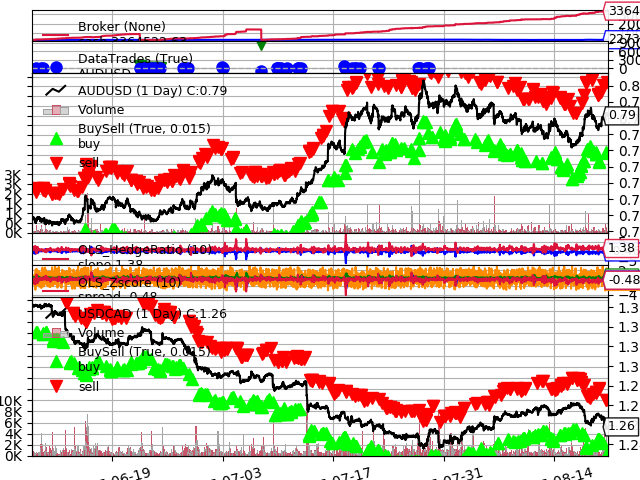

[[<matplotlib.figure.Figure at 0x7f948e36e668>]]

In [9]:
# Report
cerebro.plot()  

In [ ]:
strat0 = strats[0]
pyfolio = strat0.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio.get_pf_items()
# returns.to_csv('D:/Projects/PyQuantTrader/strategies/returns.csv')
# positions.to_csv('D:/Projects/PyQuantTrader/strategies/positions.csv')
# transactions.to_csv('D:/Projects/PyQuantTrader/strategies/transactions.csv')
# gross_lev.to_csv('D:/Projects/PyQuantTrader/strategies/gross_lev.csv')

# print('-- RETURNS')
# print(returns)
# print('-- POSITIONS')
# print(positions)
# print('-- TRANSACTIONS')
# print(transactions)
# print('-- GROSS LEVERAGE')
# print(gross_lev)

import pyfolio as pf
# PyFolio and backtrader
# pf.create_round_trip_tear_sheet(returns, positions, transactions)
benchmark_rets = pd.Series([0.0004] * len(returns.index), index=returns.index)   
pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=benchmark_rets,
                          live_start_date='2017-07-10')